In [36]:
%matplotlib inline

In [37]:
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
import matplotlib.pyplot as plt
import matplotlib.image as img

Initialize dataset and random seed (for reproducible results)

In [38]:
(X_train_raw, y_train_raw), (X_test_raw, y_test_raw) = mnist.load_data()

# make immutable: we want to keep this data.
X_train_raw.flags.writeable = False
X_test_raw.flags.writeable = False
y_train_raw.flags.writeable = False
y_test_raw.flags.writeable = False

# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)

Visualize data

X_train shape: (60000, 28, 28)
y_train shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


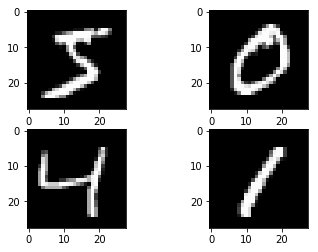

In [50]:
print("X_train shape:", X_train_raw.shape)
print("y_train shape:", y_train_raw.shape)
print("X_test shape:", X_test_raw.shape)
print("y_test shape:", y_test_raw.shape)

# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train_raw[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_raw[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_raw[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_raw[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [40]:
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train_raw.shape[1] * X_train_raw.shape[2]
X_train_flattened = X_train_raw.reshape(X_train_raw.shape[0], num_pixels).astype('float32')
X_test_flattened = X_test_raw.reshape(X_test_raw.shape[0], num_pixels).astype('float32')
print("X_train_flattened shape:", X_train_flattened.shape)
print("X_test_flattened shape:", X_test_flattened.shape)

X_train_flattened shape: (60000, 784)
X_test_flattened shape: (10000, 784)


In [41]:
# normalize inputs from 0-255 to 0-1
X_train = X_train_flattened / 255
X_test = X_test_flattened / 255
print("X_train shape: still", X_train.shape)
print("X_test shape: still", X_test.shape)

X_train shape: still (60000, 784)
X_test shape: still (10000, 784)


In [42]:
# one hot encode outputs
y_train = np_utils.to_categorical(y_train_raw)
y_test = np_utils.to_categorical(y_test_raw)
num_classes = y_test.shape[1]
print("y_test[1]: ", y_test[1])

y_test[1]:  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


In [43]:
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [44]:
def visualize_model(model):
    for layer in model.layers:
        print("input:", layer.input)
        print("output:", layer.output)
        print("units:", layer.units)

In [45]:
# build the model
model = baseline_model()
visualize_model(model)
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

input: Tensor("dense_17_input:0", shape=(?, 784), dtype=float32)
output: Tensor("dense_17/Relu:0", shape=(?, 784), dtype=float32)
units: 784
input: Tensor("dense_17/Relu:0", shape=(?, 784), dtype=float32)
output: Tensor("dense_18/Softmax:0", shape=(?, 10), dtype=float32)
units: 10
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
 - 8s - loss: 0.2787 - acc: 0.9209 - val_loss: 0.1418 - val_acc: 0.9571
Epoch 2/10
 - 7s - loss: 0.1117 - acc: 0.9676 - val_loss: 0.0925 - val_acc: 0.9711
Epoch 3/10
 - 7s - loss: 0.0717 - acc: 0.9797 - val_loss: 0.0792 - val_acc: 0.9770
Epoch 4/10
 - 7s - loss: 0.0501 - acc: 0.9859 - val_loss: 0.0747 - val_acc: 0.9769
Epoch 5/10
 - 7s - loss: 0.0371 - acc: 0.9892 - val_loss: 0.0680 - val_acc: 0.9781
Epoch 6/10
 - 7s - loss: 0.0269 - acc: 0.9926 - val_loss: 0.0634 - val_acc: 0.9800
Epoch 7/10
 - 7s - loss: 0.0207 - acc: 0.9949 - val_loss: 0.0629 - val_acc: 0.9807
Epoch 8/10
 - 8s - loss: 0.0143 - acc: 0.9968 - val_loss: 0.0645 - val_acc: 0.9783
Epoc

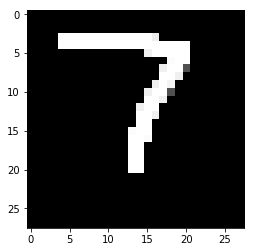

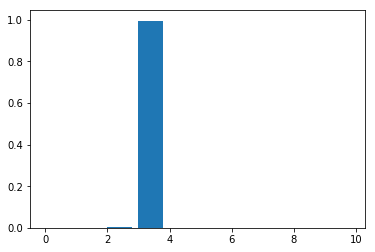

Most likely: 3


In [46]:
fromfile = img.imread("../drawingboard/digit.png")
reduced = fromfile[:,:,0]
plt.imshow(reduced, cmap=plt.get_cmap('gray'))
plt.show()
test = reduced.reshape(784)
predicted = model.predict(numpy.array([test]), 1)
plt.bar([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], predicted[0], align='edge')
plt.show()
print("Most likely:", numpy.argmax(predicted))